In [1]:
from qiskit_dynamics import Solver, DynamicsBackend
from qiskit_dynamics.backend import default_experiment_result_function
from qiskit_dynamics.array import Array
import jax
from qiskit.providers.fake_provider import *
from qiskit import pulse

/home/riccardo/.venv/lib/python3.10/site-packages/qiskit_dynamics/dispatch/backends/jax.py:34: UserWarning: The functionality in the perturbation module of Qiskit Dynamics requires a JAX version <= 0.4.6, due to a bug in JAX versions > 0.4.6. For versions 0.4.4, 0.4.5, and 0.4.6, using the perturbation module functionality requires setting os.environ['JAX_JIT_PJIT_API_MERGE'] = '0' before importing JAX or Dynamics.
  warnings.warn(


In [2]:
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper, ParityMapper
import numpy as np
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.second_q.drivers import PySCFDriver
import os

#gate_backend = provider.get_backend('simulator_statevector')

gate_backend =FakeManila()
gate_backend.configuration().hamiltonian['qub'] = {'0': 2,'1': 2,'2': 2,'3': 2,'4': 2}
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")
Array.set_default_backend("jax")
pulse_backend = DynamicsBackend.from_backend(gate_backend, evaluation_mode="sparse")
solver_options = {"method": "jax_odeint", "atol": 1e-6, "rtol": 1e-8}
pulse_backend.set_options(solver_options=solver_options)
pulse_backend.configuration = lambda: gate_backend.configuration()
print("Porte logiche supportate dal backend Fake_Manila:", gate_backend.configuration().basis_gates)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


Porte logiche supportate dal backend Fake_Manila: ['id', 'rz', 'sx', 'x', 'cx', 'reset']


In [3]:
from qiskit_nature import settings
settings.use_pauli_sum_op = False

In [4]:
from qiskit_nature.second_q.transformers import FreezeCoreTransformer,ActiveSpaceTransformer
import re
my_dict = {}

def get_qubit_op(dist):
    # Define Molecule
    ultra_simplified_ala_string = f"""
    H 0.0 0.0 0.0
    H 0.0 0.0 {dist}
    """
    
    driver = PySCFDriver(
        atom=ultra_simplified_ala_string.strip(),
        basis='sto3g',
        unit=DistanceUnit.ANGSTROM
    )
    qmolecule = driver.run()
    num_active_electrons = 2
    num_active_orbitals = 2
    as_transformer = ActiveSpaceTransformer(num_active_electrons,num_active_orbitals)
    problem = as_transformer.transform(qmolecule)
    mapper = ParityMapper(num_particles = problem.num_particles)
    qubit_op = mapper.map(problem.second_q_ops()[0])
    '''num_active_electrons = 2
    num_active_orbitals = 2
    as_transformer = ActiveSpaceTransformer(num_active_electrons,num_active_orbitals)
    problem = as_transformer.transform(qmolecule)
    mapper = ParityMapper(num_particles = problem.num_particles)
    qubit_op = mapper.map(problem.second_q_ops()[0])
    print(qubit_op)'''
    for pauli in qubit_op:
        #print(pauli)
        str_info = pauli.__str__()
        #print(f"Rappresentazione della stringa: {str_info}")
    
        # Estrai i coefficienti
        coeffs_start = str_info.find("coeffs=[") + len("coeffs=[")
        coeffs_end = str_info.find("]", coeffs_start)
        coeffs_str_complex = complex(str_info[coeffs_start:coeffs_end].strip())
        coeffs_str = coeffs_str_complex.real
        #print(coeffs_str)
        
        # Estrai gli operatori come stringa
        operators_start = str_info.find("[") + len("[")
        operators_end = str_info.find("])", operators_start)
        operators_str = str_info[operators_start:operators_end].strip()
        label_start = operators_str.find("'") + 1
        label_end = operators_str.find("'", label_start)
        label = operators_str[label_start:label_end]
        #print(label)
    
        '''# Utilizza espressioni regolari per estrarre la parte reale e immaginaria dei coefficienti
        coeffs_match = re.findall(r"(-?\d+\.\d+)([+-]\d+\.\d+j)?", coeffs_str)
    
        # Inizializza i coefficienti come float
        real_coeffs = [float(match[0]) for match in coeffs_match]
        imag_coeffs = [float(match[1]) if match[1] else 0.0 for match in coeffs_match]
    
        # Somma i coefficienti complessi
        complex_coeff = sum(complex(real, imag) for real, imag in zip(real_coeffs, imag_coeffs))'''
    
        # Aggiungi il coefficiente all'operatore nel dizionario
        #current_coeff = my_dict.get(operators_str, 0.0)
        #my_dict[operators_str] = coeffs_str
        my_dict[label] = coeffs_str
        
        
    return qubit_op, my_dict,problem,problem.nuclear_repulsion_energy

In [5]:
from qiskit.pulse import Schedule, GaussianSquare, Drag, Delay, Play, ControlChannel, DriveChannel

def drag_pulse(backend, amp, angle):
  backend_defaults = backend.defaults()
  inst_sched_map = backend_defaults.instruction_schedule_map
  x_pulse = inst_sched_map.get('x', (0)).filter(channels = [DriveChannel(0)], instruction_types=[Play]).instructions[0][1].pulse
  duration_parameter = x_pulse.parameters['duration']
  sigma_parameter = x_pulse.parameters['sigma']
  beta_parameter = x_pulse.parameters['beta']
  pulse1 = Drag(duration=duration_parameter, sigma=sigma_parameter, beta=beta_parameter, amp=amp, angle=angle)
  return pulse1

In [6]:
def cr_pulse(backend, amp, angle, duration):
  backend_defaults = backend.defaults()
  inst_sched_map = backend_defaults.instruction_schedule_map
  cr_pulse = inst_sched_map.get('cx', (1, 0)).filter(channels = [ControlChannel(0)], instruction_types=[Play]).instructions[0][1].pulse
  cr_params = {}
  cr_params['duration'] = cr_pulse.parameters['duration']
  cr_params['amp'] = cr_pulse.parameters['amp']
  cr_params['angle'] = cr_pulse.parameters['angle']
  cr_params['sigma'] = cr_pulse.parameters['sigma']
  cr_params['width'] = cr_pulse.parameters['width']
  cr_risefall = (cr_params['duration'] - cr_params['width']) / (2 * cr_params['sigma'])
  angle_parameter = angle
  duration_parameter =  duration
  sigma_parameter = cr_pulse.parameters['sigma']
  width_parameter = int(duration_parameter - 2 * cr_risefall * cr_params['sigma'])
  #declare pulse parameters and build GaussianSquare pulse
  pulse1 = GaussianSquare(duration = duration_parameter, amp = amp, angle = angle_parameter, sigma = sigma_parameter, width=width_parameter)
  return pulse1

In [7]:
def sx_pulse(backend, amp, angle):
    backend_defaults = backend.defaults()
    inst_sched_map = backend_defaults.instruction_schedule_map
    h_pulse = h_pulse = inst_sched_map.get('sx', 1).filter(channels = [ControlChannel(0)], instruction_types=[Play]).instructions[0][1].pulse
    duration_parameter = h_pulse.parameters['duration']
    sigma_parameter = h_pulse.parameters['sigma']
    beta_parameter = h_pulse.parameters['beta']
    pulse1 = Drag(duration=duration_parameter, sigma=sigma_parameter, beta=beta_parameter, amp=amp, angle=angle)
    return pulse1

In [8]:
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv

class MyCustomCallback(BaseCallback):
    def __init__(self, max_timesteps, verbose=0):
        super(MyCustomCallback, self).__init__(verbose)
        self.max_timesteps = max_timesteps
        self.current_timesteps = 0
        self.rewards = []
        self.timesteps = []

    def _on_step(self) -> bool:
        self.current_timesteps += 1
        self.rewards.append(self.locals['rewards'])
        self.timesteps.append(self.num_timesteps)
        print(f"Current timestep: {self.current_timesteps}")
        if self.current_timesteps >= self.max_timesteps:
            print(f"Max timesteps reached ({self.max_timesteps}). Stopping training.")
            return False  # Restituisce False per fermare il training
        return True

2024-09-11 16:55:33.235682: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-11 16:55:33.373943: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-11 16:55:33.412038: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-11 16:55:35.505810: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [9]:
import gym
from gym import spaces
from gym import Env, spaces

class QuantumEnv(Env):
    def __init__(self):
        super(QuantumEnv,self).__init__()
        self.available_gates = ['x', 'cx']
        self.ansatz = []
        self.max_gates = 10
        #spazio delle azioni
        self.action_space = spaces.Discrete(2 * len(self.available_gates))
        #spazio degli stati
        self.observation_space = spaces.MultiDiscrete([len(self.available_gates) + 1] * self.max_gates)
        self.actions = []

    def reset(self):
        self.ansatz = []
        return self._get_obs()

    def _get_obs(self):
        # Rappresenta l'ansatz corrente come una lista di indici dei gate
        obs = [self.available_gates.index(gate) if gate in self.available_gates else len(self.available_gates) 
               for gate in self.ansatz]
        # Riempie fino a max_gates con un indice fuori dai limiti
        obs += [len(self.available_gates)] * (self.max_gates - len(obs))
        return np.array(obs, dtype=np.int32)

    def step(self, action):
        info = {}
        self.actions.append(action)
        if len(self.actions) > 5:
            return self._get_obs(), 0, True, info
        # Aggiungi o rimuovi un gate in base all'azione
        if action < len(self.available_gates):  # Aggiungi un gate
            if len(self.ansatz) < self.max_gates:
                self.ansatz.append(self.available_gates[action])
        else:  # Rimuovi un gate
            gate_to_remove = self.available_gates[action - len(self.available_gates)]
            if gate_to_remove in self.ansatz:
                self.ansatz.remove(gate_to_remove)
    
        # Esegui il VQE per calcolare l'energia
        dist = 0.735
        n_qubit = 2
        parameters = 7
        LC = gen_LC_vqe(parameters)
        n_shot = 1024
        optimizer = 'COBYLA'
        noiseless_estimator = Estimator(approximation=True)
        params = np.zeros(parameters)
    
        (qubit_op, my_dict, problem, REPULSION_ENERGYproblem) = get_qubit_op(dist)
    
        #print('Distanza:', dist)
        print('Ansatz:', self.ansatz)
        vqe_res = minimize(vqe, params, args=(my_dict, pulse_backend, gate_backend, n_qubit, n_shot, self.ansatz),
                           method=optimizer, constraints=LC, options={'rhobeg':0.1, 'maxiter':0})
        
        # Calcola la ricompensa
        reward = np.log((-(vqe_res.fun + REPULSION_ENERGYproblem))**2)
        print('reward: ',reward)

        # Verifica se l'ambiente è terminato (massimo numero di gate)
        terminated = len(self.ansatz) >= self.max_gates


        #print('pulse_VQE:',vqe_res.fun + REPULSION_ENERGYproblem)
        dump_dir = '/tmp/foo'
        # Controlla se la directory esiste e poi la elimina con tutto il suo contenuto
        if os.path.exists(dump_dir):
            try:
                shutil.rmtree(dump_dir)
                print(f"Directory {dump_dir} eliminata con successo.")
            except Exception as e:
                print(f"Errore durante l'eliminazione della directory {dump_dir}: {e}")
        
        # Restituisci osservazione, ricompensa, stato finito e informazioni aggiuntive
        truncated = False
        done = truncated or terminated
        return self._get_obs(), reward, done, info


    def HE_pulse(backend, amp, angle, width, ansatz):
        with pulse.build(backend) as my_program1:
            sched_list = []
            for gate in ansatz:
                if gate == 'x':
                    with pulse.build(backend) as sched1:
                        qubits = (0, 1)
                        for i in range(2):
                            pulse.play(drag_pulse(backend, amp[i], angle[i]), DriveChannel(qubits[i]))
                    sched_list.append(sched1)
            
                elif gate == 'cx':
                     with pulse.build(backend) as sched2:
                        uchan = pulse.control_channels(0, 1)[0]
                        pulse.play(cr_pulse(backend, amp[0], angle[2], width[0]), uchan)
                     sched_list.append(sched2)
    
    
            with pulse.build(backend) as my_program:
                with pulse.transpiler_settings(initial_layout=[0, 1]):
                    with pulse.align_sequential():
                        for sched in sched_list:
                            pulse.call(sched)
    
        duration_in_cycles = my_program.duration
        dt = backend.configuration().dt
        duration_in_ns = duration_in_cycles * dt * 1e9  # conversione in nanosecondi
    
        '''print(f"Durata totale del programma di impulsi: {duration_in_ns} ns")
        print('--------------------------------------------------------------------')
        print(my_program)
        print('--------------------------------------------------------------------')'''
        return my_program

In [10]:
import copy
import time
from scipy.optimize import minimize, LinearConstraint

def measurement_pauli(prepulse, pauli_string, backend, n_qubit):
    with pulse.build(backend) as pulse_measure:
        pulse.call(copy.deepcopy(prepulse))
        for ind,pauli in enumerate(pauli_string):
            if(pauli=='X'):
                pulse.u2(0, np.pi, ind)
            if(pauli=='Y'):
                pulse.u2(0, np.pi/2, ind)
        for qubit in range(n_qubit):
            pulse.barrier(qubit)
        pulse.measure(range(n_qubit))
    return pulse_measure

def n_one(bitstring, key):
    results = 0
    for ind,b in enumerate(reversed(bitstring)):
        if((b=='1')&(key[ind]!='I')):
            results+=1
    return results

def expectation_value(counts,shots,key):
    results = 0
    for bitstring in counts:
        if(n_one(bitstring, key)%2==1):
            results -= counts[bitstring]/shots
        else:
            results += counts[bitstring]/shots
    return results

def run_pulse_sim(meas_pulse, key, pulse_backend, backend, n_shot):
    # Misura il tempo di esecuzione della funzione run
    start_time_run = time.time()
    job = pulse_backend.run(meas_pulse, shots=n_shot)
    #job = backend.run(meas_pulse)
    run_time = time.time() - start_time_run

    # Monitora il job
    #job_monitor(job)
    
    # Misura il tempo di esecuzione per ottenere i risultati
    start_time_result = time.time()
    counts = job.result().get_counts()
    result_time = time.time() - start_time_result
    
    # Calcola l'aspettativa
    start_time_expectation = time.time()
    expectation = expectation_value(counts, n_shot, key)
    expectation_time = time.time() - start_time_expectation
    #print('Tempo di esecuzione:',result_time)
    return expectation

def gen_LC_vqe(parameters):
    lb = np.zeros(parameters)
    ub = np.ones(parameters)
    LC = (LinearConstraint(np.eye(parameters),lb,ub,keep_feasible=False))
    return LC

In [11]:
def vqe_one(prepulse,n_qubit,n_shot,pulse_backend, backend,key,value):
    all_Is = True
    for key_ele in key:
        if(key_ele!='I'):
            all_Is = False
    if(all_Is):
        return value
    meas_pulse = measurement_pauli(prepulse=prepulse, pauli_string=key, backend=backend, n_qubit=n_qubit)
    return value*run_pulse_sim(meas_pulse, key, pulse_backend, backend, n_shot)

In [12]:
def vqe(params,pauli_dict,pulse_backend, backend,n_qubit,n_shot, ansatz):
    #print("params in def chemistry in vqe.py: ", params)
    # assert(len(params)%2==0)
    width_len = int(len(params)-1*(n_qubit-1))
    split_ind = int(width_len/3)
    amp = np.array(params[:split_ind])
    angle = np.array(params[split_ind:width_len])*np.pi*2
    width_1 = (np.array(params[width_len:]))
    num_items = (1024 - 256) // 16 + 1
    width_norm = (width_1 - 256) / (1024 - 256)
    width_norm = np.clip(width_norm, 0, 1)
    width = (np.round(width_norm * (num_items - 1)) * 16 + 256).astype(int)
    amp = amp.tolist()
    angle = angle.tolist()
    width = width.tolist()
    keys = [key for key in pauli_dict]
    values = [pauli_dict[key] for key in pauli_dict]
    expect_values = []

    for key, value in zip(keys, values):
        prepulse = QuantumEnv.HE_pulse(backend, amp, angle, width, ansatz)
        expect = vqe_one(prepulse, n_qubit, n_shot, pulse_backend, backend, key, value)
        expect_values.append(expect)
    #print("E for cur_iter: ",sum(expect_values))
    return sum(expect_values)

/tmp/ipykernel_36543/2141399085.py:1: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.optimizers import SPSA, SLSQP, COBYLA
/home/riccardo/.venv/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cpu device
Inizio dell'apprendimento...


/home/riccardo/.venv/lib/python3.10/site-packages/pyscf/dft/libxc.py:771: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


Ansatz: ['cx']
reward:  -3.631041218270119
Current timestep: 1
Ansatz: ['cx', 'cx']
reward:  -3.631041218270119
Current timestep: 2
Ansatz: ['cx', 'cx']
reward:  -3.631041218270119
Current timestep: 3
Ansatz: ['cx']
reward:  -3.631041218270119
Current timestep: 4
Ansatz: []
reward:  -2.2029759055531426
Current timestep: 5
Max timesteps reached (5). Stopping training.
Apprendimento completato.


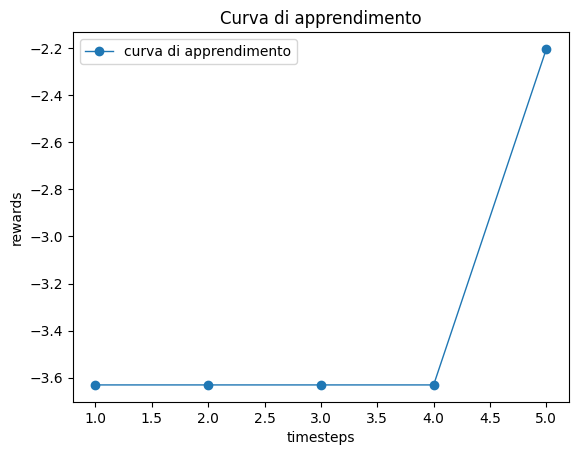

In [13]:
from qiskit.algorithms.optimizers import SPSA, SLSQP, COBYLA
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver
from qiskit_aer.primitives import Estimator
import matplotlib.pyplot as plt

max_timesteps = 5
callback = MyCustomCallback(max_timesteps=max_timesteps)
env = DummyVecEnv([lambda: QuantumEnv()])
# Agente RL
model = PPO("MlpPolicy", env, verbose=1)

print("Inizio dell'apprendimento...")
model.learn(total_timesteps= int(5), callback=callback)
print("Apprendimento completato.")

plt.plot(callback.timesteps, callback.rewards, marker = "o", linewidth = 1.0, label = "curva di apprendimento")
plt.xlabel("timesteps")
plt.ylabel("rewards")
plt.legend()
plt.title("Curva di apprendimento")
output_path = 'apprend.png'
plt.savefig(output_path)
plt.show()

In [14]:
'''from stable_baselines3.common.evaluation import evaluate_policy
episodes = 5
for episode in range(1, episodes+1):
    print('EPISODIO:',episode)
    state = env.reset()
    done = False
    score = 0
    while not done:
        env.render()
        action, _ = model.predict(state)
        n_state, reward, done,_= env.step(action)
        print('stato:',n_state)
        state = n_state
        score += reward

        if done:
            break
    print(f'Episode:{episode} Score:{score}')

env.close()'''

"from stable_baselines3.common.evaluation import evaluate_policy\nepisodes = 5\nfor episode in range(1, episodes+1):\n    print('EPISODIO:',episode)\n    state = env.reset()\n    done = False\n    score = 0\n    while not done:\n        env.render()\n        action, _ = model.predict(state)\n        n_state, reward, done,_= env.step(action)\n        print('stato:',n_state)\n        state = n_state\n        score += reward\n\n        if done:\n            break\n    print(f'Episode:{episode} Score:{score}')\n\nenv.close()"